In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image,ImageDraw,ImageFont
from tqdm.auto import tqdm

In [18]:
img : str = '/home/USER/Documents/Uni/WiSe2223/Consulting/mlw-consulting-project/data/interim/lemmata_img/images/959.jpg'

In [14]:
0.017714565619826317


def generate_image(path: str, lemma: str) -> np.ndarray:
    

    # sample text and font
    font = ImageFont.truetype("/home/USER/.local/share/fonts/Affectionately Yours - TTF.ttf", 256, encoding="unic")

    # get the line size
    _, _, text_width, text_height = font.getbbox(lemma)

    # create a blank canvas with extra space between lines
    canvas = Image.new('RGB', (text_width + 40, text_height + 40), "white")

    # draw the text onto the text canvas, and use blue as the text color
    draw = ImageDraw.Draw(canvas)
    draw.text((40,0), lemma, 'black', font)

    # Open original image
    image = Image.open(path)

    # Get ratio of original image of generated image
    ratio = np.array(np.shape(image)[0:2]) / np.array(np.shape(canvas)[0:2])
    x_r, y_r = ratio

    # Get ratio
    mask = np.array([np.all(np.array((x_r * np.array(np.shape(canvas)[0:2])), dtype=int) <= np.array(np.shape(image)[0:2], dtype=int)), np.all(np.array((y_r * np.array(np.shape(canvas)[0:2])), dtype=int) <= np.array(np.shape(image)[0:2], dtype=int))])
    r = ratio[mask]
    new_canvas = canvas.resize(np.flip(np.array((r * np.array(np.shape(canvas)[0:2])), dtype=int)), Image.Resampling.LANCZOS)
    h, w = np.array(np.divide(np.array(np.shape(image)[0:2]) -  np.array(np.shape(new_canvas)[0:2]), 2), dtype=int)

    # Fill boundaries to match size
    white_canvas = np.uint8(np.ones(np.shape(image), dtype=int) * 255)
    white_canvas[h:(np.shape(new_canvas)[0] + h), w:(w + np.shape(new_canvas)[1])] = new_canvas
    
    # Compute difference between sizes and sum up
    diff: float = np.sum(np.array(np.shape(image)) - np.array(np.shape(new_canvas)))
    return white_canvas, image, diff

In [4]:
a, d = generate_image('/home/USER/Documents/Uni/WiSe2223/Consulting/mlw-consulting-project/data/interim/lemmata_img/images/959.jpg', "kalendae")

In [5]:
d

11

In [21]:
np.shape(a)

(126, 408, 3)

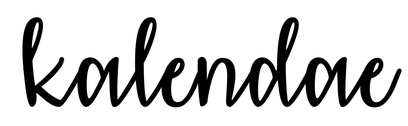

In [6]:
Image.fromarray(a)

In [19]:
path_data_json = "/home/USER/Documents/Uni/WiSe2223/Consulting/mlw-consulting-project/data.json"
path_images = "/home/USER/Documents/Uni/WiSe2223/Consulting/mlw-consulting-project/data/interim/lemmata_img/images"

In [8]:
df = pd.read_json(path_data_json)

In [12]:
progress_bar = tqdm(range(len(df)))
# imgs: list = []
deltas: list = []
for row in df.iterrows():
    id = row[1][0]
    lemma = row[1][1]
    path = os.path.join(path_images, (str(id) + ".jpg"))
    try:
        _, delta = generate_image(path, lemma)
        # imgs.append(img)
        deltas.append(delta)
        progress_bar.update(1)
    except Exception:
        deltas.append(None)
        progress_bar.update(1)
        continue

  0%|          | 0/114653 [00:00<?, ?it/s]

In [13]:
df['deltas'] = deltas

In [17]:
df = df.dropna()

In [22]:
df_sorted = df.sort_values(by=['deltas'])

In [19]:
df.to_json("data_with_deltas.json")

In [27]:
df_sorted.iloc[20000]

id        135164
lemma     tempus
deltas      22.0
Name: 40277, dtype: object

# Write New Dataset for CycleGAN

In [4]:
df: pd.DataFrame = pd.read_json('data_with_deltas.json')

In [5]:
df_sorted = df.sort_values(by=['deltas'])

In [6]:
df_sorted.iloc[20000]

id        135164
lemma     tempus
deltas        22
Name: 40277, dtype: object

In [8]:
df_final: pd.DataFrame = df_sorted.iloc[0:20000]
df_final = df_final.sample(frac=1)


In [9]:
df_sorted.iloc[20000]

id        135164
lemma     tempus
deltas        22
Name: 40277, dtype: object

In [10]:
df_final.head(100)

,id,lemma,deltas
17169,55926,similis,5
81523,272032,laetus,2
94067,287304,mater,7
42294,185176,tandem,20
111278,305215,necessitas,12
...,...,...,...
47059,195729,turmatim,2
109534,303471,natus,0
67917,220197,tu,17
79706,233275,timor,17


In [11]:
from pathlib import Path
Path("machine2lemma/").mkdir(parents=True, exist_ok=True)
Path("machine2lemma/train").mkdir(parents=True, exist_ok=True)
Path("machine2lemma/train/machine").mkdir(parents=True, exist_ok=True)
Path("machine2lemma/train/lemma").mkdir(parents=True, exist_ok=True)
Path("machine2lemma/test").mkdir(parents=True, exist_ok=True)
Path("machine2lemma/test/machine").mkdir(parents=True, exist_ok=True)
Path("machine2lemma/test/lema").mkdir(parents=True, exist_ok=True)

In [12]:
df_train: pd.DataFrame = df_final[0:18000]
df_test: pd.DataFrame = df_final[18000::]

In [20]:
def generate_ds(df: pd.DataFrame, data_root: str, lemma_img_path: str, target: str, source: str) -> None:
    progress_bar = tqdm(range(len(df)))
    for row in df.iterrows():
        id = row[1][0]
        lemma = row[1][1]
        gen, image, diff = generate_image(os.path.join(lemma_img_path, str(id) + '.jpg'), lemma)
        # Source is machine
        gen = Image.fromarray(gen)
        source_path: str = os.path.join(data_root, source, str(id) + '.jpg')
        gen.save(source_path)
        # target is lemma
        target_path: str = os.path.join(data_root, target, str(id) + '.jpg')
        image.save(target_path)
        progress_bar.update(1)

In [21]:
df_test_method = df.iloc[0:10]

In [24]:
generate_ds(df_test_method, "machine2lemma/train", path_images, 'lemma', 'machine')

  0%|          | 0/10 [00:00<?, ?it/s]